In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

if os.getcwd() == '/content':
  % cd drive/MyDrive/exjobb_project

print(os.getcwd())

!pip install transformers
!pip install sentencepiece

/content/drive/MyDrive/exjobb_project
/content/drive/MyDrive/exjobb_project
     |████████████████████████████████| 1.9MB 7.4MB/s 
     |████████████████████████████████| 890kB 19.2MB/s 
     |████████████████████████████████| 3.2MB 55.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d6fac550dfe2e560734b8459e93ddc679ec82b44d4bec2c359c8e4292a7df8ac
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 10.0MB/s 


In [3]:
from transformers import BertModel
from transformers import BertTokenizer
from transformers import PretrainedConfig
from transformers import XLNetModel, XLNetTokenizer

# testing different loading of models
#from transformers import AutoModel, AutoTokenizer

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import json
import time
import regex as re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

%matplotlib inline

In [4]:
# use an RNG seed for reproducibility
seed_list = [2, 4, 8]

SEED = seed_list[1]

# set the RNG seed
np.random.seed(SEED)
torch.manual_seed(SEED)

# summary of current run
summary = f'SEED: {SEED}'

In [5]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions/sessions_02.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms/symptoms_02.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
print(f'Numer of symptoms in id2sym: {len(sym2id)}')

if False:
    # remove labels that have less than m occurrences
    m = 0

    labels_list = df['confirmed'].tolist()
    labels_list = sum(labels_list, [])
    c = Counter(labels_list)
    for i in range(len(df)):
        to_remove = []
        
        # find labels that should be removed 
        for j in range(len(df['confirmed'][i])):
            if c[df['confirmed'][i][j]] < m:
                to_remove.append(j)
                
        # remove the labels
        shift = 0
        for j in range(len(to_remove)):
            df['confirmed'][i].pop(to_remove[j]-shift)
            shift += 1

        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)

# remove unused columns
df.drop('confirmed', inplace=True, axis=1)
#df.drop('suggested', inplace=True, axis=1)

Numer of symptoms in id2sym: 245


In [6]:
print(f'Number of samples in df: {len(df)}')

if False:
    # check if there are duplicates and remove them if found
    dup_set = set()
    dup_count = 0

    for ind, row in df.iterrows():
        temp_tup = (row['text'], tuple(row['labels']))
        if temp_tup in dup_set:
            # remove text if the size is larger than 40
            #if len(row['text']) > 40:
                #print(f'Dropping index {ind} with text: {row["text"]}')
                df.drop(ind, inplace=True)
                dup_count += 1
        else:
            dup_set.add((row['text'], tuple(row['labels'])))
    df = df.reset_index(drop=True)

    print(f'Removed {dup_count} duplicates')
    print(f'Number of samples in df after removal: {len(df)}')


df.head()

Number of samples in df: 6540


,text,suggested,labels
0,Har fått besvärlig eksem på händerna,[141],"[Hudbesvär, Synliga hudbesvär]"
1,Muskelsvaghet och trötthet känner mig skakig o...,"[12, 97, 215, 359, 518, 606]","[Muskelsvaghet, Trötthet]"
2,Vår son har röda hudutslag i nacke och knävecken,[141],"[Hudbesvär, Synliga hudbesvär]"
3,hosta 5 dagar,[43],[Hosta]
4,Huvudvärk,[54],[Huvudvärk]


In [7]:
# choose which transformer model to use

# ELECTRA models
path_to_model = r'./bert/electra-small-swedish-cased-discriminator'
#path_to_model = r'./bert/electra-base-swedish-cased-discriminator'

# BERT models
#path_to_model = r'./bert/bert-base-cased'
#path_to_model = r'./bert/bert-base-swedish-cased'
#path_to_model = r'./bert/bert-base-multilingual-cased'

# XLNet models
#path_to_model = r'./xlnet/xlnet-base-cased'

print(f'Model path: {path_to_model}')
summary += f'\nModel path: {path_to_model}'

tok = None
if re.search(r'xlnet', path_to_model):
    tok = XLNetTokenizer.from_pretrained(path_to_model)
    print('Using XLNetTokenizer')
    summary += f'\nTokenizer: XLNetTokenizer'
elif re.search(r'bert', path_to_model):
    tok = BertTokenizer.from_pretrained(path_to_model, do_lower_case=False)
    print('Using BertTokenizer')
    summary += f'\nTokenizer: BertTokenizer'

# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)
summary += f'\nNumber of labels: {len(multilab_bin.classes_)}'


class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, multilab_bin, max_len):
        self.tokenizer = tokenizer
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            #'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
            'labels': torch.tensor(self.multilab_bin.transform([self.labels[index]]).reshape(-1,), dtype=torch.float)
        }        

Model path: ./bert/electra-small-swedish-cased-discriminator
Using BertTokenizer


In [8]:
batch_size = 16
summary += f'\nBatch size: {batch_size}'

# max number of tokens in text
max_len = 0
for i in range(len(df['text'])):
    text = df['text'][i]
    inputs = tok.encode_plus(
            text,
            None,
            add_special_tokens=True,
            padding=False,
            return_token_type_ids=True
            )
    
    if len(inputs['input_ids']) >= max_len:
        print(len(inputs['input_ids']))
        print(df['text'][i])
        print(inputs['input_ids'])
        print(tok.convert_ids_to_tokens(inputs['input_ids']))
        max_len = len(inputs['input_ids'])
if max_len > 250:
    max_len = 250
print(f'Max token length: {max_len}')
summary += f'\nMax token sequence length: {max_len}'


train_dataset, test_dataset = train_test_split(df,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = CustomDataset(train_dataset, tok, multilab_bin, max_len)
test_set = CustomDataset(test_dataset, tok, multilab_bin, max_len)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

summary += f'\nTraining set: {len(train_dataset)} samples\nTest set: {len(test_dataset)} samples'

9
Har fått besvärlig eksem på händerna 
[2, 1177, 902, 21553, 3171, 11581, 68, 8657, 3]
['[CLS]', 'Har', 'fått', 'besvärlig', 'ek', '##sem', 'på', 'händerna', '[SEP]']
20
Muskelsvaghet och trötthet känner mig skakig och en viss svullnad kring händerna. 
[2, 26260, 257, 42528, 147, 36, 25632, 2007, 680, 7494, 33, 36, 59, 1783, 33659, 457, 1885, 8657, 7, 3]
['[CLS]', 'Musk', '##els', '##vag', '##het', 'och', 'trötthet', 'känner', 'mig', 'skak', '##ig', 'och', 'en', 'viss', 'svull', '##nad', 'kring', 'händerna', '.', '[SEP]']
80
Jag har exem och har fått utslag på händerna, armvecken och vid tinningen. Min kortisonsalva är iprincip helt slut och har endast en mjukgörande salva men jag känner inte att den hjälper och det känns som att den gör att jag kliar ännu mer på natten i sömnen. Jag skulle behöva en ny kortisonsalva för att få bort mina besvär. 
[2, 361, 108, 1237, 36, 108, 902, 10108, 68, 8657, 19, 3198, 769, 5, 36, 252, 31157, 251, 7, 2310, 1337, 8117, 7612, 384, 54, 42651, 849, 18

In [9]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
    summary += f'\nCUDA device: {torch.cuda.get_device_name(0)}'
else:
    dev = 'cpu'
    summary += '\nCUDA device: None'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
  print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Tesla P100-PCIE-16GB


In [10]:
class BERTClass(nn.Module):
    def __init__(self, config, path_to_bert, output_dim):
        super(BERTClass, self).__init__()
        #config = PretrainedConfig.from_json_file(f'{path_to_bert}/config.json')
        self.bert = BertModel.from_pretrained(path_to_bert)
        #self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, output_dim)
        self.sigm = nn.Sigmoid()
        
    def forward(self, ids, mask, token_type_ids):
        x = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.dropout(x[1])
        x = self.fc(x)
        output = self.sigm(x)
        return output

class XLNetClass(nn.Module):
    def __init__(self, config, path_to_model, output_dim):
        super(XLNetClass, self).__init__()
        self.transformer = XLNetModel.from_pretrained(path_to_model)

        # - - - - Imitate BertPooler - - - -
        #self.dense = nn.Linear(config.d_model, config.d_model)
        #self.tanh = nn.Tanh()
        # - - - - - - - - - - - - - - - - - - -

        self.dropout = nn.Dropout(config.summary_last_dropout)

        self.fc = nn.Linear(config.d_model, output_dim)
        self.sigm = nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer(ids, attention_mask=mask, token_type_ids=token_type_ids)

        # - - - - Imitate BertPooler - - - -
        x = x[0][:, -1] # use the CLS token
        #x = self.dense(x)
        #x = self.tanh(x)
        # - - - - - - - - - - - - - - - - - -

        x = self.dropout(x)
        x = self.fc(x)
        output = self.sigm(x)
        return output


In [11]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [12]:
# define the model
D_out = len(multilab_bin.classes_)

config = PretrainedConfig.from_json_file(f'{path_to_model}/config.json')

# choose appropriate nn.module class based on pathname
model = None
if re.search(r'xlnet', path_to_model):
    model = XLNetClass(config, path_to_model, D_out)
    #print('Using XLNetClass')
    summary += '\nUModel class: XLNetClass'
elif re.search(r'bert', path_to_model):
    model = BERTClass(config, path_to_model, D_out)
    #print('Using BertClass')
    summary += '\nModel class: BertClass'

model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

print(summary)

Some weights of the model checkpoint at ./bert/electra-small-swedish-cased-discriminator were not used when initializing BertModel: ['electra.embeddings.position_ids', 'electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.Laye

SEED: 4
Model path: ./bert/electra-small-swedish-cased-discriminator
Tokenizer: BertTokenizer
Number of labels: 217
Batch size: 16
Max token sequence length: 174
Training set: 5232 samples
Test set: 1308 samples
CUDA device: Tesla P100-PCIE-16GB
Model class: BertClass


In [13]:

model.train()

# training loop
learning_rate = 0.00005

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# if the test loss has not improved in the last k epochs, stop training
k = 5

num_epochs = 100
for epoch in range(num_epochs):
    # keep track of time taken per epoch
    start_time = time.time()

    for idx,batch in enumerate(train_loader):
        ids = batch['ids'].to(device, dtype=torch.long)
        mask = batch['mask'].to(device, dtype=torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
        labels = batch['labels'].to(device, dtype=torch.float)
        
        # forward pass
        outputs = model(ids, mask, token_type_ids)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}, Time elapsed: {time.time()-start_time:.2f} s')

    # if the test loss has not improved in the last k epochs break
    if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
      print(f'Test loss has not improved in the last {k} epochs. Stopping ...')
      break

End of epoch 1, Train Loss: 0.0687254, Test Loss: 0.0692135, Time elapsed: 36.00 s
End of epoch 2, Train Loss: 0.0457088, Test Loss: 0.0463300, Time elapsed: 35.99 s
End of epoch 3, Train Loss: 0.0404835, Test Loss: 0.0412264, Time elapsed: 35.85 s
End of epoch 4, Train Loss: 0.0385373, Test Loss: 0.0393127, Time elapsed: 35.82 s
End of epoch 5, Train Loss: 0.0376303, Test Loss: 0.0384296, Time elapsed: 35.80 s
End of epoch 6, Train Loss: 0.0371493, Test Loss: 0.0379955, Time elapsed: 35.69 s
End of epoch 7, Train Loss: 0.0368749, Test Loss: 0.0377258, Time elapsed: 36.01 s
End of epoch 8, Train Loss: 0.0367166, Test Loss: 0.0375990, Time elapsed: 35.76 s
End of epoch 9, Train Loss: 0.0366024, Test Loss: 0.0374810, Time elapsed: 35.91 s
End of epoch 10, Train Loss: 0.0365332, Test Loss: 0.0374207, Time elapsed: 35.75 s
End of epoch 11, Train Loss: 0.0364893, Test Loss: 0.0373699, Time elapsed: 35.99 s
End of epoch 12, Train Loss: 0.0364597, Test Loss: 0.0373691, Time elapsed: 35.88 s
E

In [14]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

model.eval()  
y_pred_temp, y_true = get_pred_true(model, test_loader, D_out)

SEED: 4
./bert/electra-small-swedish-cased-discriminator
Number of labels in training set: 211/217 (97.24 %)
Number of labels in test set: 149/217 (68.66 %)
Number of labels present in both sets: 143/217 (65.90 %)

Micro-average F1-score: 0.6237350505979761
Weighted-average F1-score: 0.5380403720679915
Macro-average F1-score: 0.37985115218588117
Accuracy (exact match): 0.3333333333333333
Hamming Loss: 0.005763891824856608


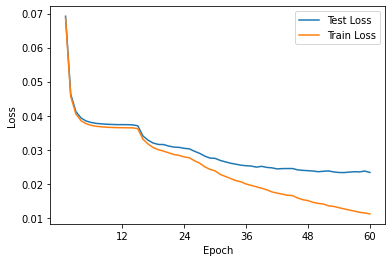

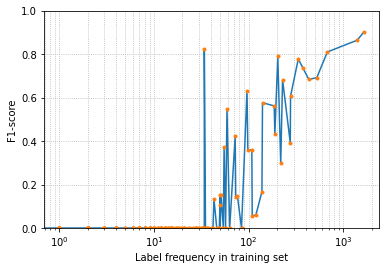

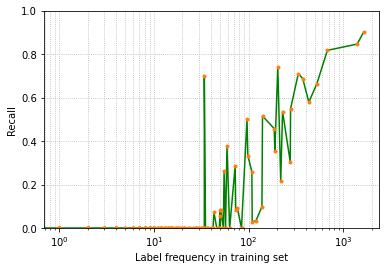

In [15]:
# set all values above threshold to 1, else 0
th = 0.5
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(f'SEED: {SEED}')
print(path_to_model)
print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot f1-score in relation to label frequency in training set
f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)

# also plot recall in relation to label frequency in training set
recall_per_label = recall_score(y_true, y_pred, average=None, zero_division=0)

# only include labels that are present in the test set
zipped = [(f1_per_label[i], recall_per_label[i], label_counts_test[i], label_counts_train[i]) for i in range(len(label_counts_test)) if label_counts_test[i] > 0]
zipped = sorted(zipped, key=lambda tup: tup[-1])

f1_per_label = [zipped[i][0] for i in range(len(zipped))]
recall_per_label = [zipped[i][1] for i in range(len(zipped))]
label_counts_train = [zipped[i][-1] for i in range(len(zipped))]

# plot f1-score in relation to label frequency in training set
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(label_counts_train, f1_per_label)
plt.plot(label_counts_train, f1_per_label, '.')
ax.set_xscale('log')
ax.set_ylim((0,1))
plt.xlabel('Label frequency in training set')
plt.ylabel('F1-score')
plt.grid(True, which='both', linestyle=':')
plt.show()

# plot recall in relation to label frequency in training set
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(label_counts_train, recall_per_label, 'g')
plt.plot(label_counts_train, recall_per_label, '.', color='#ff7f0e')
ax.set_xscale('log')
ax.set_ylim((0,1))
plt.xlabel('Label frequency in training set')
plt.ylabel('Recall')
plt.grid(True, which='both', linestyle=':')
plt.show()

In [ ]:
# write custom text for testing out the model

text = ''

inputs = tok.encode_plus(
    text,
    None,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding='max_length',
    return_token_type_ids=True
)
ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)

# get the prediction
y_pred_row = model(ids, mask, token_type_ids).detach().cpu()

y_pred_row[y_pred_row > th] = 1
y_pred_row[y_pred_row <= th] = 0

# print symptoms
print(multilab_bin.inverse_transform(y_pred_row))

In [17]:
model.eval()

# get a list of tuples containing the samples sorted by loss
sorted_samples = []

for i in range(len(test_dataset)):
    text = str(test_dataset['text'][i])
    text = ' '.join(text.split())

    inputs = tok.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
    token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)
    
    # get the prediction
    y_pred_row = model(ids, mask, token_type_ids).detach().cpu()

    # get the true labels
    y_true_row = torch.tensor(multilab_bin.transform([test_dataset['labels'][i]]), dtype=torch.float)

    # get the loss
    loss = criterion(y_pred_row, y_true_row)

    # convert predictions according to threshold
    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0

    # get the suggested labels
    y_suggested_row = test_dataset['suggested'][i]

    sorted_samples.append((y_pred_row, y_true_row, y_suggested_row, text, loss))

# sort samples with regard to loss
sorted_samples = sorted(sorted_samples, key=lambda tup: tup[-1])

In [ ]:
# print the m percent best/worst predictions based on loss
m = 50
best_worst = 'best'

nbr_elements = (len(test_dataset) * m) // 100

top_m = []
if best_worst == 'best':
  top_m = sorted_samples[:nbr_elements]
elif best_worst == 'worst':
  top_m = sorted_samples[len(sorted_samples)-nbr_elements:]
else:
  print('Please choose either "best" or "worst"')

for i in range(len(top_m)):
  tup = top_m[i]
  pred = multilab_bin.inverse_transform(tup[0])
  labels = multilab_bin.inverse_transform(tup[1])
  suggested = [id2sym[j] for j in tup[2] if j in id2sym]
  text = tup[3]
  loss = tup[-1]

  print(f'Loss: {loss}')
  print(f'{text}')
  print(f'Prediction: {pred}')
  print(f'Labels: {labels}')
  print(f'Suggested: {suggested}')
  print('- - - - - - - - - - - - - - - - - - - - - - - - -')